Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Training model...
Overall AUC: 0.9029


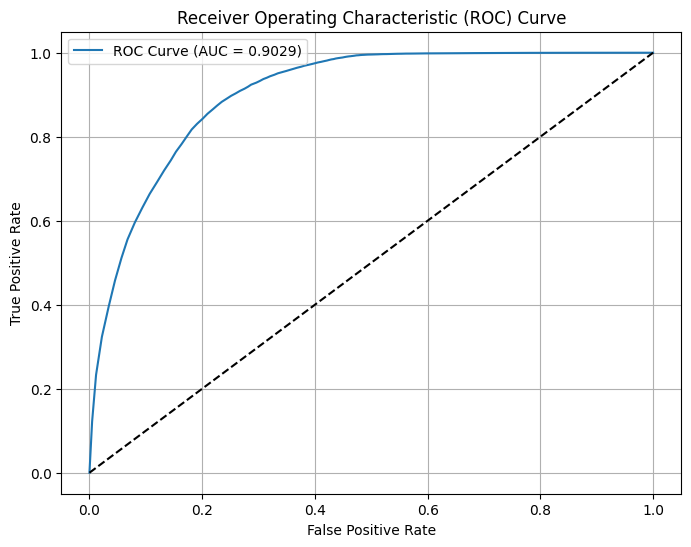


--- Subgroup Analysis ---

AUC by Education Level:
  Bachelor's: 0.9076
  High School: 0.8991
  Other: 0.9003
  Master's: 0.8962
  PhD: 0.9029

AUC by Loan Purpose (Sorted):
Top 3 Performing Purposes:
  Business: 0.9168
  Home: 0.9080
  Education: 0.9056
Bottom 3 Performing Purposes:
  Debt consolidation: 0.9027
  Other: 0.8917
  Vacation: 0.8917


In [56]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd


import pandas as np
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve


#loading the data
df = pd.read_csv('/content/loan_data.csv', on_bad_lines='skip')

# Drop rows where the target variable 'loan_paid_back' is NaN
df = df.dropna(subset=['loan_paid_back'])

# Separating the Features and Target
# Dropping 'id' as it is not a predictive feature
X = df.drop(['id', 'loan_paid_back'], axis=1)
y = df['loan_paid_back']

# Defining the feature groups below
numeric_features = ['annual_income', 'debt_to_income_ratio', 'credit_score',
                    'loan_amount', 'interest_rate']
categorical_features = ['gender', 'marital_status', 'education_level',
                        'employment_status', 'loan_purpose']
# 'grade_subgrade' has a clear ordering (A1 < A2 ... < F5), so i will use Ordinal Encoding
ordinal_features = ['grade_subgrade']

# Splitting data into Train and Test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Creating the Preprocessing Pipeline
# We explicitly sort the grades to ensure A1 is mapped to 0, A2 to 1, etc.
sorted_grades = sorted(X['grade_subgrade'].unique())

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('ord', OrdinalEncoder(categories=[sorted_grades]), ordinal_features)
    ])

# ==========================================
# 3. Model Development
# ==========================================

# Initialize Random Forest Pipeline
# class_weight='balanced' handles the imbalance between Paid/Default classes
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100,
                                          random_state=42,
                                          class_weight='balanced',
                                          n_jobs=-1))
])

# Train the model
print("Training model...")
model.fit(X_train, y_train)

# Predict Probabilities on Test Set
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Calculate Overall AUC
overall_auc = roc_auc_score(y_test, y_pred_proba)
print(f"Overall AUC: {overall_auc:.4f}")

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {overall_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--') # Diagonal random guess line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.grid(True)
plt.show()

# ==========================================
# 4. Subgroup Analysis
# ==========================================

print("\n--- Subgroup Analysis ---")

# Combine test features with actuals and predictions for analysis
analysis_df = X_test.copy()
analysis_df['y_true'] = y_test
analysis_df['y_prob'] = y_pred_proba

# Function to calculate AUC for a subgroup
def get_subgroup_auc(df, column):
    results = {}
    for group in df[column].unique():
        subset = df[df[column] == group]
        # Calculate AUC only if both classes (0 and 1) are present in the subset
        if len(subset['y_true'].unique()) > 1:
            auc = roc_auc_score(subset['y_true'], subset['y_prob'])
            results[group] = auc
    return results

# 4a. Analysis by Education Level
print("\nAUC by Education Level:")
edu_aucs = get_subgroup_auc(analysis_df, 'education_level')
for edu, score in edu_aucs.items():
    print(f"  {edu}: {score:.4f}")

# 4b. Analysis by Loan Purpose
print("\nAUC by Loan Purpose (Sorted):")
purpose_aucs = get_subgroup_auc(analysis_df, 'loan_purpose')
sorted_purposes = sorted(purpose_aucs.items(), key=lambda x: x[1], reverse=True)

print("Top 3 Performing Purposes:")
for p, score in sorted_purposes[:3]:
    print(f"  {p}: {score:.4f}")

print("Bottom 3 Performing Purposes:")
for p, score in sorted_purposes[-3:]:
    print(f"  {p}: {score:.4f}")